https://iopscience.iop.org/article/10.1088/1555-6611/aaf63d 
H Ahmad et al 2019 Laser Phys. 29 025301

Generate refractive index and effective mode area

start


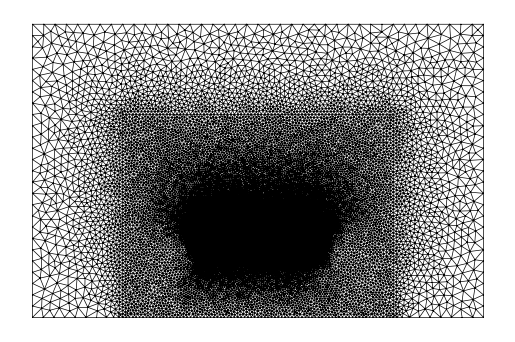

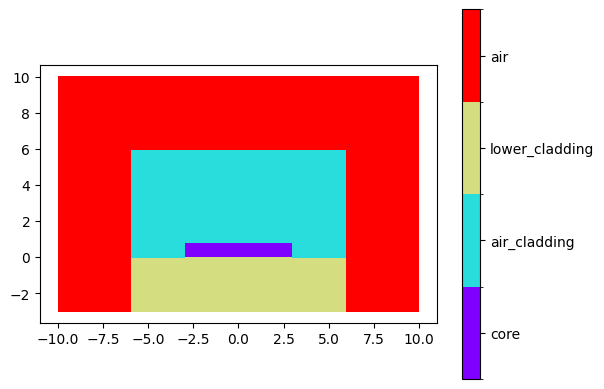

  0%|          | 0/75 [00:00<?, ?it/s]

effective area:2.2013470818264467


  1%|▏         | 1/75 [00:45<56:34, 45.87s/it]

effective area:2.2541904909825554


  3%|▎         | 2/75 [01:25<51:12, 42.09s/it]

effective area:2.3024016787122363


  4%|▍         | 3/75 [02:00<46:50, 39.03s/it]

In [ ]:
import shapely
from SCG_Stimulation.Benchmark.generate_neff_and_aeff import get_neff_and_aeff
from SCG_Stimulation.refractive_index import n_MgF2, n_Si3N4, n_Air
from collections import OrderedDict
import numpy as np

# waveguide parameters
width = 6  # um
height = 0.8  # um
thickness = 0.8  # um

n2 = 2.5e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.7  # loss (dB/cm)

wavelength_range = [207, 5500]
wavelegnth_step = 75  #  steps

n_core = n_Si3N4
n_lower_cladding = n_MgF2
n_air = n_Air

# Construct waveguide geometry
core = shapely.geometry.box(-width / 2, 0, +width / 2, height)
lower_cladding = shapely.geometry.box(-6, -3, 6, 0)
air_cladding = shapely.geometry.box(-6, 0, 6, 6)
air = shapely.geometry.box(-10, -3, 10, 10)
polygons = OrderedDict(core=core,lower_cladding=lower_cladding,air_cladding=air_cladding,air=air)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.04, "distance": 0.2},
                   air_cladding={"resolution": 0.15, "distance": 0.5},  #100nm, let it fall over 300nm
                   lower_cladding={"resolution": 0.15, "distance": 0.5},
                   air={"resolution": 0.5, "distance": 1})

n_dict = {"core": n_core, "lower_cladding": n_lower_cladding, "air_cladding": n_air, "air": n_air}

print("start")
# Calculate dispersion and gamma
aeff_list, neff_list, wls = get_neff_and_aeff(polygons, n_dict, wavelength_range, wavelegnth_step, resolutions)

##plot data
np.savez(f"data_h_{height}_w_{width}_1", wls=wls, aeff_list=aeff_list, neff_list=neff_list)

print("end")
print(aeff_list)
print(wls)


Reproduce Fig 4 to verify the stimulated effective area and nonlinear coefficent

0.32038327415917656


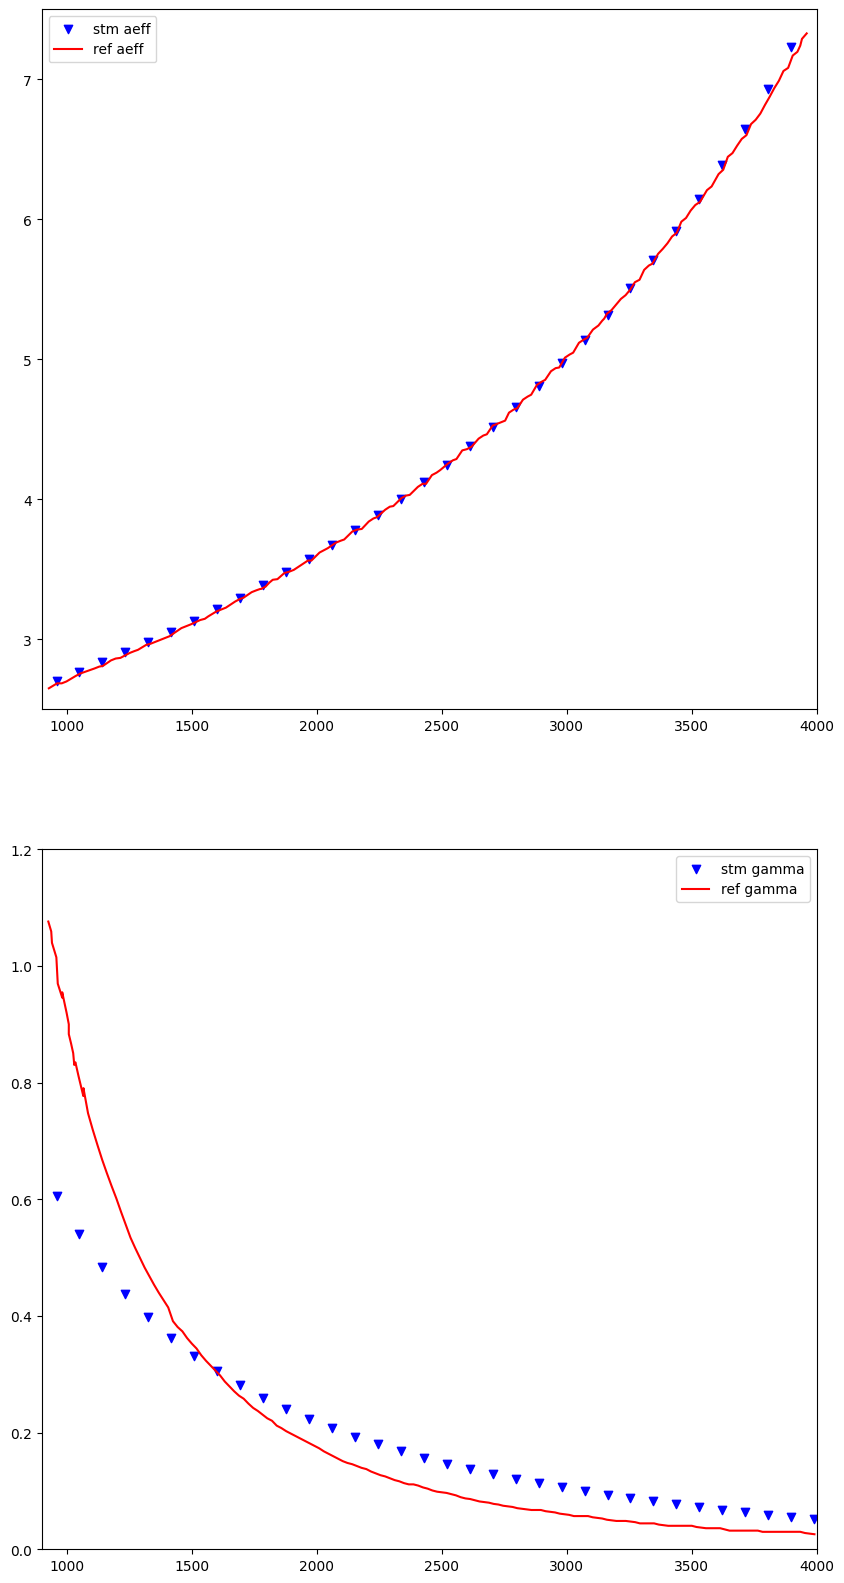

In [76]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

data = np.load("data_h_0.8_w_6.npz")
wls = data['wls']
c_mks = 299792458.0
n2 = 2.5e-19
pulseWL = 1550
aeff_list = data['aeff_list']
aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)


# Calculate Gamma
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * 1e-9 * aeff_interp(pump_wl) * 1e-12)
    return gamma


gamma_list = list(map(gamma_function, wls))
gamma_interp = scipy.interpolate.interp1d(wls, gamma_list)
print(gamma_interp(1550))

# Read reference aeff and gamma value from the file
aeff_x, aeff_y = list(np.split(pd.read_csv(
    "./aeff.csv", dtype=np.float64
).values, 2, axis=1))

g_x, g_y = list(np.split(pd.read_csv(
    "./gamma.csv", dtype=np.float64
).values, 2, axis=1))

# Plot aeff graph
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20))
ax1.scatter(wls, aeff_list, marker="v", c="b", label="stm aeff")
ax1.plot(aeff_x, aeff_y, c="r", label="ref aeff")
ax1.legend()

ax1.set_xlim(900, 4000)
ax1.set_ylim(2.5, 7.5)

# Plot gamma graph
ax2.scatter(wls, gamma_list, marker="v", c="b", label="stm gamma")
ax2.plot(g_x, g_y, c="r", label="ref gamma")
ax2.legend()

ax2.set_xlim(900, 4000)
ax2.set_ylim(0, 1.2)
plt.show()

Replicate the spectrum of Fig 5d)


0.3199392310619748
[ 500.          591.83673469  683.67346939  775.51020408  867.34693878
  959.18367347 1051.02040816 1142.85714286 1234.69387755 1326.53061224
 1418.36734694 1510.20408163 1602.04081633 1693.87755102 1785.71428571
 1877.55102041 1969.3877551  2061.2244898  2153.06122449 2244.89795918
 2336.73469388 2428.57142857 2520.40816327 2612.24489796 2704.08163265
 2795.91836735 2887.75510204 2979.59183673 3071.42857143 3163.26530612
 3255.10204082 3346.93877551 3438.7755102  3530.6122449  3622.44897959
 3714.28571429 3806.12244898 3897.95918367 3989.79591837 4081.63265306
 4173.46938776 4265.30612245 4357.14285714 4448.97959184 4540.81632653
 4632.65306122 4724.48979592 4816.32653061 4908.16326531 5000.        ]
[2.04390136 2.01874006 1.99966672 1.98355071 1.96893957 1.95509638
 1.941625   1.92830509 1.91501273 1.90167927 1.88826888 1.87476562
 1.86116581 1.84747336 1.8336968  1.81984745 1.80593815 1.79198252
 1.77799441 1.76398758 1.74997548 1.73597114 1.72198705 1.7080352
 1.

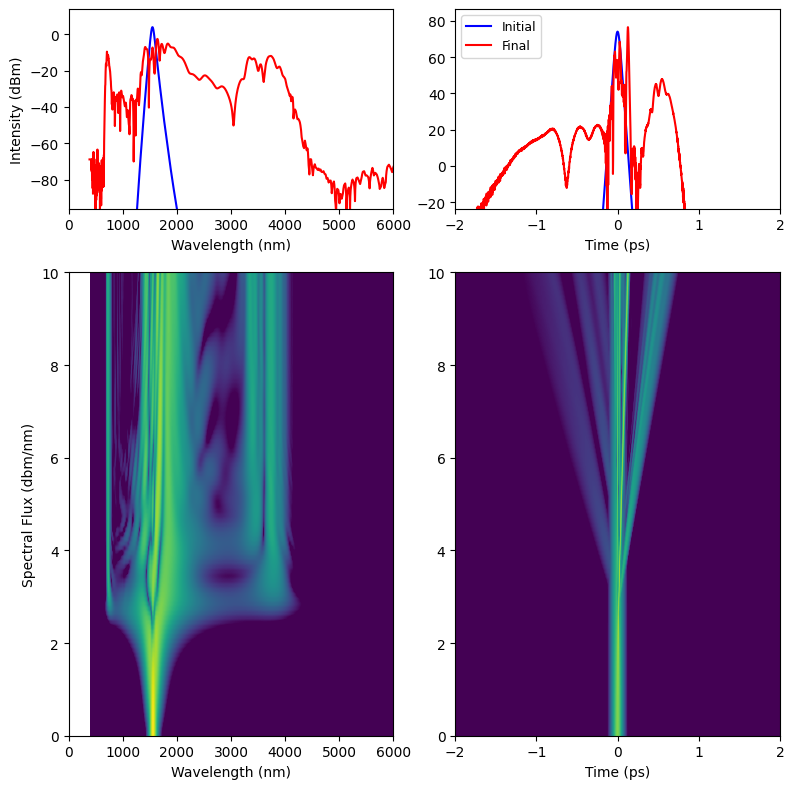

(<Figure size 800x800 with 4 Axes>,
 array([[<Axes: xlabel='Wavelength (nm)', ylabel='Intensity (dBm)'>,
         <Axes: xlabel='Time (ps)'>],
        [<Axes: xlabel='Wavelength (nm)', ylabel='Spectral Flux (dbm/nm)'>,
         <Axes: xlabel='Time (ps)'>]], dtype=object))

In [91]:
from typing import OrderedDict
import shapely
import laserfun as lf
from generate_neff_and_aeff import get_neff_and_aeff
from collections import OrderedDict
import scipy
import numpy as np

# pulse parameters
FWHM = 50 * 1e-3  # pulse duration (ps)
pulseWL = 1550  # pulse central wavelength (nm)

power = 5000  # W
GDD = False  # Group delay dispersion (ps^2)
TOD = False  # Third order dispersion (ps^3)
FOD = False  # Fourth order dispersion

# simulation parameters
Window = 4  # simulation window (ps)
Steps = 100  # simulation steps
Points = 2 ** 12  # simulation points
rtol = 1e-4  # relative error for NLSE integrator
atol = 1e-4  # absolute error
Raman = True  # Enable Raman effect?
Steep = True  # Enable self steepening?

# ----------- Build Waveguide -----------
# waveguide parameters
width = 6  # um
height = 0.8  # um

n2 = 2.5e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.7  # loss (dB/cm)

data = np.load("data_h_0.8_w_6.npz")
wls = data['wls']
neff_list = data['neff_list']
aeff_list = data['aeff_list']


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)


# Calculate Gamma
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * 1e-9 * aeff_interp(pump_wl) * 1e-12)
    return gamma


print(gamma_function(pulseWL))
print(wls)
print(neff_list)
# create the pulse:
p = lf.Pulse(pulse_type='sech', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, power_is_avg=False, wav=wls, power=power)

# create the waveguide
f = lf.Fiber(10 * 1e-3, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma_function(pulseWL), loss_dB_per_m=Alpha * 100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)

results.plot(wavelength=True, show=True, tlim=(-2, 2), flim=(0, 6000))
